# Hand-drawn shape detection using a neural network

# Abstract

In this notebook we train a neural network to categorise my own hand drawn shapes labelling each image as either a circle, line or square. The ambitions for this project are two-fold, firstly, my ambition in studying deep learning was to use artificial intelligence to solve my own problems from my own datasets. Secondly, as a rule of thumb, neural networks typically need 1000 examples of each category to successfully train a model. As I do not have the patience to draw 3000 shapes I will be training this neural network using a small number of images (30 per shape) and a variety of data augmentation techniques to expand the dataset to over 3000 examples. The network will then be validated and tested on the remaining images (30 per shape). This emulates a realistic scenario in which data gathering is expensive or time consuming. The neural network is trained in augmented data, however, the network will be validated and tested against non-augmented data, from the original dataset. 

# Contents

<ul>
    <li>Importing and processing augmented dataset</li>
    <li>
        Training neural network
        <ul>
            <li>Defining neural network geometry</li>
            <li>Random hyperparameter search</li>
            <li>Convergence of the cost function</li>
        </ul>
    </li>
    <li>Validation dataset</li>
    <li>Regularisation to prevent overfitting</li>
    <li>Testing neural network</li>
    <li>Conclusion</li>
</ul>

# Importing and processing augmented dataset

In [1]:
from PIL import Image
import numpy as np

Import augmented training dataset. Each image has dimensions 25x25 and hence when flattened has 625 features. We import 3240 images in to a numpy matrix as X with dimensions (3240,625).

In [2]:
num_images = 1080*3
resolu_images = 25**2
file_list = [r"circles\train\circle_",r"lines\train\line_",r"squares\train\square_"]
X = np.zeros([num_images, resolu_images])
counter = 0
for i in range(3):
    for j in range(1080):
        file_name = file_list[i] + str(j+1) + ".jpg"
        X[counter] = np.matrix.flatten(np.array(Image.open(file_name).convert('L')))
        counter += 1
    print("Imported files: {}".format(file_list[i]))

Imported files: circles\train\circle_
Imported files: lines\train\line_
Imported files: squares\train\square_


In [3]:
X.shape

(3240, 625)

Each feature has an RGB value between 0 and 255 which we now normalise.

In [4]:
#Normalise RGB values
X = X / 255

We now define our target class as y with dimensions (3240,1). Each image is either a circle (0), a line (1) or a square (2).

In [5]:
y = np.genfromtxt("train_target_class.csv", delimiter=',')
y = y.reshape((num_images,1))

In [6]:
y

array([[0.],
       [0.],
       [0.],
       ...,
       [2.],
       [2.],
       [2.]])

In [7]:
y.shape

(3240, 1)

# Data augmentation

To artificially incraese the amount of training data we can utilise data augmentatio. For each image we flip, rotate, blur and sharpen increasing the original dataset of 90 (30 per shape) to 3240 (1080 per shape). As few exmaples of these are below.

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline 

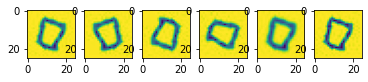

In [9]:
fig, axs = plt.subplots(1,6)
fig_indices = [2160, 2160+30, 2160+60, 2160+120, 3240-720,3240-360]
for i in range(6):
    axs[i].imshow(X[fig_indices[i]].reshape((25,25)))

# Training neural network

### Defining neural network hyperparameters

We now train a neural network on this augmented data. We utilise a softmax neural network which are typically used for catagorisation problems. In this work we will make an initial assumption that a sufficiently sophisticated network can be trained on three layers (two hidden layers). To decide other hyperparameters such as the number of units per layer and the learning rate we perform a random search. We will randomly initialize hyperparameters between sensible limits and see which sets of parameters give timely and controlled minimisation of the cost function.

### Random hyperparameter search

Units in hidden layer 1: Integer value rounded from $10^a$ for $1 \leq a \leq 3$.

Units in hidden layer 2: Integer value rounded from $10^b$ for $-2 \leq b \leq 0$ times the units in hidden layer 1.

Learning rate: Value $\alpha = 10^c$ for $-7 \leq c \leq -1$.

The number of layers in the output layer is fixed to the number of classes (3). We pick the activation function of the hidden layers to be "relu". The activation function of the output layer is linear using logits (equivalent to softmax). For each set of random hyperparameters we plot the loss over 50 epochs. We are looking for hyperparameters that yield a timely yet smooth decrease in loss.

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

In [11]:
num_iters = 20
num_epochs = 50
l_1_units_list = []
l_2_units_list = []
l_3_units_list = []
learning_rate_val_list = []
J_list = np.zeros((num_epochs,num_iters))

for k in range(num_iters):    
    np.random.seed(42 + k)
    #Random search of hyperparameters
    l_1_units = int(10**(np.random.rand()*2 + 1))
    l_2_units = int(l_1_units / (10**(0.5 + np.random.rand())))
    l_3_units = int(l_2_units / (10**(0.5 + np.random.rand())))
    learning_rate_val = 10**(-np.random.rand()*3 - 3)
    
    l_1_units_list.append(l_1_units)
    l_2_units_list.append(l_2_units)
    l_3_units_list.append(l_3_units)
    learning_rate_val_list.append(learning_rate_val)
    
    tf.random.set_seed(1234) # for consistent results
    model = Sequential(
        [               
            ### START CODE HERE ### 
            Dense(units=l_1_units, activation='relu'),
            Dense(units=l_2_units, activation='relu'),
            Dense(units=l_3_units, activation='relu'),
            Dense(units=3, activation='linear')
            ### END CODE HERE ### 
        ], name = "my_model" 
    )
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_val),)
    history = model.fit(X, y, epochs=num_epochs, verbose=0)
    J_list[:,k] = history.history['loss']

Out of each set of hyperparameters it seems that set 10 provides a steady yet timely decrease in the cost function.

(Text(0, 0.5, 'Cost function'), Text(0.5, 0, 'Epochs'))

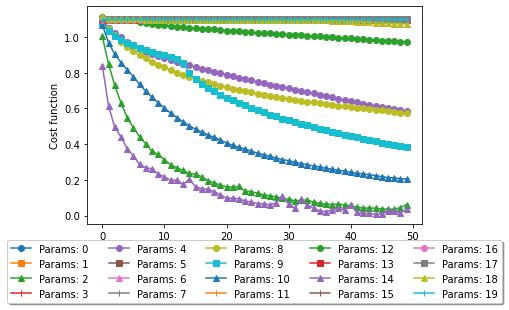

In [12]:
marker_list = ["o","s","^","|"]
for k in range(num_iters):
    plt.plot(J_list[:,k], label = "Params: {}".format(k), marker=marker_list[k % 4])
    plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.ylabel("Cost function"), plt.xlabel("Epochs")

In [21]:
k = 10
print("For parameters k={}: layer 1 has {} units, layer 2 has {} units and layer 3 has {} units.".format(k, l_1_units_list[k], l_2_units_list[k], l_3_units_list[k]))
print("For parameters k={}: the learning rate is {}.".format(k, learning_rate_val_list[k], l_2_units_list[k]))

For parameters k=10: layer 1 has 442 units, layer 2 has 131 units and layer 3 has 25 units.
For parameters k=10: the learning rate is 1.3955155880057205e-05.


### Convergence of the cost function

Lets test convergence over more epochs.

In [13]:
num_epochs = 500    
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [               
        ### START CODE HERE ### 
        Dense(units=442, activation='relu'),
        Dense(units=131, activation='relu'),
        Dense(units=25, activation='relu'),
        Dense(units=3, activation='linear')
        ### END CODE HERE ### 
    ], name = "my_model" 
)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(learning_rate=1.29e-05),)
history = model.fit(X, y, epochs=num_epochs, verbose=0)
J = history.history['loss']

We reach convergence in the cost function in 500 epochs!

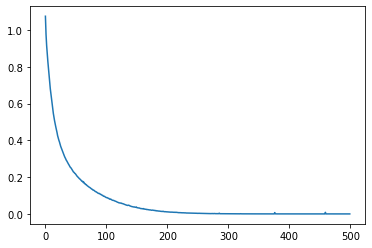

In [14]:
plt.plot(J)

102/102 [==============================] - 0s 3ms/step


(Text(0, 0.5, 'Cost function'), Text(0.5, 0, 'Epochs'))

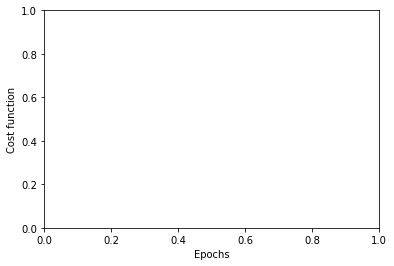

In [15]:
prediction = model.predict(X)
prediction_p = tf.nn.softmax(prediction)
y_hat = np.zeros((len(prediction_p),1))
for i in range(len(y_hat)):
    y_hat[i] = np.argmax(prediction_p[i])
plt.ylabel("Cost function"), plt.xlabel("Epochs")

We can see that our neural network predicts the test data we get an accuracy of 100%. This tells us that our model is sufficiently large enough to predict such results. If we could not reach high accuracy on training data we would need to increase the size of the network.

In [16]:
np.sum(y_hat == y)/len(y)

1.0

# Validation dataset

Lets load in our validation dataset. Note that our validation data is raw data and not augmented like our training data.

In [17]:
num_images = 15*3
resolu_images = 25**2
file_list = [r"circles\valid\circle_",r"lines\valid\line_",r"squares\valid\square_"]
X_valid = np.zeros([num_images, resolu_images])
counter = 0
for i in range(3):
    for j in range(15):
        file_name = file_list[i] + str(j+1) + ".jpg"
        X_valid[counter] = np.matrix.flatten(np.array(Image.open(file_name).convert('L')))
        counter += 1
    print("Imported files: {}".format(file_list[i]))

Imported files: circles\valid\circle_
Imported files: lines\valid\line_
Imported files: squares\valid\square_


Normalise validation data.

In [18]:
X_valid = X_valid / 255

In [19]:
X_valid.shape

(45, 625)

In [20]:
y_valid = np.genfromtxt("valid_target_class.csv", delimiter=',')
y_valid = y_valid.reshape((num_images,1))

In [21]:
y_valid.shape

(45, 1)

In [22]:
prediction_valid = model.predict(X_valid)
prediction_valid_p = tf.nn.softmax(prediction_valid)
y_hat_valid = np.zeros((len(prediction_valid_p),1))
for i in range(len(y_hat_valid)):
    y_hat_valid[i] = np.argmax(prediction_valid_p[i])

2/2 [==============================] - 0s 4ms/step


In [23]:
np.sum(y_hat_valid == y_valid)/len(y_valid)

0.8888888888888888

We actually achieve 89% accuracy on our validation data which is good considering we have not yet adjusted for overfitting to our training data.

# Regularisation to prevent overfitting

To prevent overfitting to the test dataset we utilise L2 regularisation. Lets perform a grid search with varying degrees of L2 regularisation to try and increase our validation dataset accuracy at the expense of training dataset accuracy.

We vary the amount of L2 regularisation with values $10^d$ where $d = [-3, -2.5, -2, -1.5, -1, -0.5, 0]$. Then the neural network is trained on the training dataset towards convergence (~300 epochs). Then the training dataset accuracy is compared to the test dataset accuracy.

In [24]:
l2_reg_val_list = 10**np.arange(-3,0,0.5)
num_iters = len(l2_reg_val_list)
num_epochs = 300
J_list = np.zeros((num_epochs,num_iters))
train_precision = []
valid_precision = []
counter = 0
for l2_reg_val in l2_reg_val_list:    
    np.random.seed(42 + k)
    
    
    tf.random.set_seed(1234) # for consistent results
    model = Sequential(
        [               
            ### START CODE HERE ### 
            Dense(units=442, activation='relu',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val)),
            Dense(units=131, activation='relu',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val)),
            Dense(units=25, activation='relu',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val)),
            Dense(units=4, activation='linear',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val))
            ### END CODE HERE ### 
        ], name = "my_model" 
    )
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=3*(10**(-5))),)
    history = model.fit(X, y, epochs=num_epochs, verbose=0)
    J_list[:,counter] = history.history['loss']
    counter +=1
    prediction_train = model.predict(X)
    prediction_train_p = tf.nn.softmax(prediction_train)
    y_hat_train = np.zeros((len(prediction_train_p),1))
    for i in range(len(y_hat_train)):
        y_hat_train[i] = np.argmax(prediction_train_p[i])
    train_precision.append(np.sum(y_hat_train==y)/len(y_hat_train))
    
    prediction_valid = model.predict(X_valid)
    prediction_valid_p = tf.nn.softmax(prediction_valid)
    y_hat_valid = np.zeros((len(prediction_valid_p),1))
    for i in range(len(y_hat_valid)):
        y_hat_valid[i] = np.argmax(prediction_valid_p[i])
    valid_precision.append(np.sum(y_hat_valid==y_valid)/len(y_valid))

2/2 [==============================] - 0s 3ms/step


We see a small increase in the validation dataset for L2 regularisation with srength 0.01, lets explore values around this number. 

(Text(0, 0.5, 'Cost function'), Text(0.5, 0, 'log(L2)'))

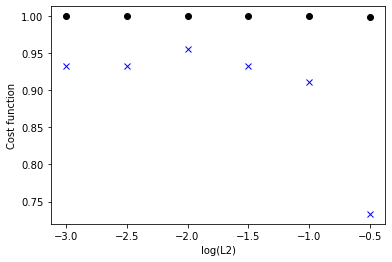

In [25]:
plt.plot(np.log10(l2_reg_val_list),train_precision,'ko',label="train precision")
plt.plot(np.log10(l2_reg_val_list),valid_precision,'bx',label="validate precision")
plt.ylabel("Cost function"), plt.xlabel("log(L2)")

Now we vary the L2 parameter strength as $10^d$ where for $d$ between $-2.375$ and $-1.5$.

In [26]:
l2_reg_val_list = 10**np.arange(-2.375,-1.5,0.125)
num_iters = len(l2_reg_val_list)
num_epochs = 300
J_list = np.zeros((num_epochs,num_iters))
train_precision = []
valid_precision = []
counter = 0
for l2_reg_val in l2_reg_val_list:    
    np.random.seed(42 + k)
    
    
    tf.random.set_seed(1234) # for consistent results
    model = Sequential(
        [               
            ### START CODE HERE ### 
            Dense(units=442, activation='relu',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val)),
            Dense(units=131, activation='relu',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val)),
            Dense(units=25, activation='relu',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val)),
            Dense(units=4, activation='linear',activity_regularizer=tf.keras.regularizers.L2(l2_reg_val))
            ### END CODE HERE ### 
        ], name = "my_model" 
    )
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=3*(10**(-5))),)
    history = model.fit(X, y, epochs=num_epochs, verbose=0)
    J_list[:,counter] = history.history['loss']
    counter +=1
    prediction_train = model.predict(X)
    prediction_train_p = tf.nn.softmax(prediction_train)
    y_hat_train = np.zeros((len(prediction_train_p),1))
    for i in range(len(y_hat_train)):
        y_hat_train[i] = np.argmax(prediction_train_p[i])
    train_precision.append(np.sum(y_hat_train==y)/len(y_hat_train))
    
    prediction_valid = model.predict(X_valid)
    prediction_valid_p = tf.nn.softmax(prediction_valid)
    y_hat_valid = np.zeros((len(prediction_valid_p),1))
    for i in range(len(y_hat_valid)):
        y_hat_valid[i] = np.argmax(prediction_valid_p[i])
    valid_precision.append(np.sum(y_hat_valid==y_valid)/len(y_valid))

2/2 [==============================] - 0s 5ms/step


We see quite large variation in the validation dataset accuracy for small changes in the L2 regularisation strength. This variation is likely demonstrating that our dataset is on the small side. For example, when $d$ is $-1.875$ we obtain 42/45 correct solutions whilst when $d$ is $-1.75$ we get 45/45 correct. If we had more data this variation would smooth out.

(Text(0, 0.5, 'Cost function'), Text(0.5, 0, 'log(L2)'))

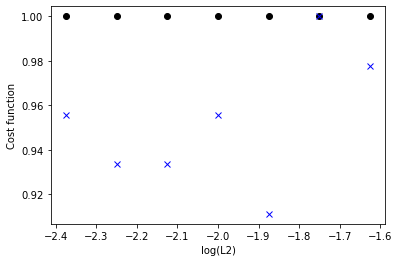

In [27]:
plt.plot(np.log10(l2_reg_val_list),train_precision,'ko',label="train precision")
plt.plot(np.log10(l2_reg_val_list),valid_precision,'bx',label="validate precision")
plt.ylabel("Cost function"), plt.xlabel("log(L2)")

Nevertheless, we will proceed with the best value of $d =  -1.75$. A note will be made that more data is needed for a validation test set. This project was meant to emulate an situation where data gathering is expensive - perhaps more of the original data should be used for validation and testing and a smaller mount of data augmented for training.

# Testing neural network

Lets import our test dataset, normalise it and test our neural network.

In [28]:
num_images = 15*3
resolu_images = 25**2
file_list = [r"circles\test\circle_",r"lines\test\line_",r"squares\test\square_"]
X_test = np.zeros([num_images, resolu_images])
counter = 0
for i in range(3):
    for j in range(15):
        file_name = file_list[i] + str(j+1) + ".jpg"
        X_test[counter] = np.matrix.flatten(np.array(Image.open(file_name).convert('L')))
        counter += 1
    print("Imported files: {}".format(file_list[i]))

Imported files: circles\test\circle_
Imported files: lines\test\line_
Imported files: squares\test\square_


In [29]:
X_test = X_test / 255

In [30]:
y_test = np.genfromtxt("test_target_class.csv", delimiter=',')
y_test = y_test.reshape((num_images,1))

In [31]:
num_epochs = 300    
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [               
        ### START CODE HERE ### 
        Dense(units=442, activation='relu',activity_regularizer=tf.keras.regularizers.L2(10**(-1.75))),
        Dense(units=131, activation='relu',activity_regularizer=tf.keras.regularizers.L2(10**(-1.75))),
        Dense(units=25, activation='relu',activity_regularizer=tf.keras.regularizers.L2(10**(-1.75))),
        Dense(units=3, activation='linear',activity_regularizer=tf.keras.regularizers.L2(10**(-1.75)))
        ### END CODE HERE ### 
    ], name = "my_model" 
)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(learning_rate=1.29e-05),)
history = model.fit(X, y, epochs=num_epochs, verbose=0)
J = history.history['loss']

In [32]:
prediction_test = model.predict(X_test)
prediction_test_p = tf.nn.softmax(prediction_test)
y_hat_test = np.zeros((len(prediction_test_p),1))
for i in range(len(y_hat_test)):
    y_hat_test[i] = np.argmax(prediction_test_p[i])

2/2 [==============================] - 0s 4ms/step


We obtain an accuracy of 93% - this is better than we obtained on our validation dataset. Due to the small amoutn of validation and test examples we can't say with certainty how effective regularisation was.

In [33]:
np.sum(y_hat_test == y_test)/len(y_test)

0.9333333333333333

We got 3/45 examples wrong. 

In [34]:
np.sum(y_hat_test != y_test)

3

Plotting the three incorrectly classified images we see that three squares (2) were incorrectly catagorised as circles (0). The first and third incorrect images are slightly rounded, which may have confused the newtork. Perhaps higher resolution images would have aided this classification. Nevertheless, I do believe a human would be able to correctly label these results as squares meaning in this case the network is performing under baseline performance. The second result is less concerning. I believe the protruding line from the square means this image is an outlier.

In [35]:
incorrect_index = np.where(y_hat_test != y_test)[0]

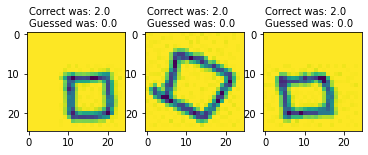

In [36]:
fig, axs = plt.subplots(1,3)
for i in range(3):
    axs[i].imshow(X_test[incorrect_index[i]].reshape((25,25)))
    axs[i].text(0,-5,"Correct was: {}".format(y_test[incorrect_index[i],0]))
    axs[i].text(0,-2,"Guessed was: {}".format(y_hat_test[incorrect_index[i],0]))

# Conclusion

To summarise, from only 180 original images we have successfully trained a neural network that can successfully distinguish lines and shapes and is over 90% successful at distinguishing low-resolution circles and squares. 

To train a more effective model several improvements could be made. More data should we including in the validation dataset, this would allow more effective tuning of the regularisation parameter which would prevent overfitting to the heavily augmented trainign dataset. 

Perhaps two validation datasets could be made - the first from the augmented dataset and the second from the non-augmented dataset. The augmeted validation set could be used to tune regularisaition that can prevent overfitting within the augmented dataset. The second, non-augmented validation dataset could instead be used to prevent overfitting to the augmented dataset. To explain this example in simple terms, imagine we trained a neural network to distinguish cats and dogs. Lets imagine we took a small selection of 15 cats from a dataset of 45 cats - to train the neural model we then augmented the training dataset by flipping, rotating and further modifying images. If in the original dataset, 14 of the 15 cats had black fur, then in the augmented training set 90% of thousands of cat examples might have black fur leading the neural network to strongly associate black fur with cats -  when in truth maybe only 50% of cats have black fur. This would be overfitting to the dataset.     

To further improve this work it may also be recommended to use a convolution neural network that could more quickly process high resolution images.